In [1]:
# Direct lammps script implemetation in pyiron 
from tempfile import tempdir
from pyiron import Project
import numpy as np
import pandas
from jinja2 import Template
import matplotlib.pyplot as plt 
import scipy.constants as sc
from scipy.integrate import cumtrapz
from ase.io import read, write
from pyiron import ase_to_pyiron, pyiron_to_ase
from pymatgen.io.vasp.outputs import Outcar
from ase.formula import Formula
import os
import json
from pymatgen.ext.matproj import MPRester#, Element
from pymatgen.entries.compatibility import MaterialsProjectCompatibility
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter, PDEntry, GrandPotentialPhaseDiagram, GrandPotPDEntry, CompoundPhaseDiagram
#from pynter import SETTINGS
#from pynter.tools.utils import save_object_as_json, get_object_from_json
import requests
from pymatgen.core.composition import Composition, Element
from pymatgen.io.vasp.outputs import Outcar
from ase.io import read, write
from ase.io.vasp import read_vasp, write_vasp 
from pymatgen.ext.matproj import MPRester #, Composition 
from pymatgen.entries.compatibility import MaterialsProjectCompatibility
from pymatgen.entries.computed_entries import ComputedEntry
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter, PatchedPhaseDiagram, CompoundPhaseDiagram, ReactionDiagram
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.analysis.reaction_calculator import ComputedReaction

from ase.spacegroup import get_spacegroup
from matplotlib import pyplot as plt
plt.style.use(['vaibhz-sci','no-latex'])#,'high-vis','vibrant'])
# I dont want the warning messages 
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Project (comparision of DFT and MD for few structures)
#pr = Project("/nfshome/deshmukh/pyiron/projects/NASICON/project/frank_glass_aimd") 
pr = Project("/nfshome/deshmukh/pyiron/projects/NASICON/project/frank_glass_aimd/nasicon_aimd") 

In [3]:
#x_3_2_3 = read('/nfshome/deshmukh/vaibhav/NaSICON_dft/database_glass/pbe_structure_0_hdf5/pbe_structure_0/CONTCAR', format='vasp')
#x_3_1_3 = read('/nfshome/deshmukh/vaibhav/NaSICON_dft/database_glass/pbe_structure_1_hdf5/pbe_structure_1/CONTCAR', format='vasp')
#x_5_2_2 = read('/nfshome/deshmukh/vaibhav/NaSICON_dft/database_glass/pbe_structure_2_hdf5/pbe_structure_2/CONTCAR', format='vasp')
#x_6_1_6 = read('/nfshome/deshmukh/vaibhav/NaSICON_dft/database_glass/pbe_structure_3_hdf5/pbe_structure_3/CONTCAR', format='vasp')
#x_6_1_5 = read('/nfshome/deshmukh/vaibhav/NaSICON_dft/database_glass/pbe_structure_4_hdf5/pbe_structure_4/CONTCAR', format='vasp')

In [10]:
x_0 = read('/nfshome/deshmukh/vaibhav/NaSICON_dft/database/pbe_structure_8_hdf5/pbe_structure_8/CONTCAR')
x_3 = read('/nfshome/deshmukh/vaibhav/NaSICON_dft/database/pbe_structure_9_hdf5/pbe_structure_9/CONTCAR')
x_2 = read('/nfshome/deshmukh/vaibhav/NaSICON_dft/database/pbe_structure_13_hdf5/pbe_structure_13/CONTCAR') # order 
x_2_1 = read('/nfshome/deshmukh/vaibhav/NaSICON_dft/database/pbe_structure_10_hdf5/pbe_structure_10/CONTCAR') # order
x_1_5 = read("/nfshome/deshmukh/vaibhav/NaSICON_dft/other_nasicon_compositions_1/nasi_x_1_5_random_hdf5/nasi_x_1_5_random/CONTCAR")
x_2_5 = read("/nfshome/deshmukh/vaibhav/NaSICON_dft/database_unstable/pbe_structure_4_hdf5/pbe_structure_4/CONTCAR")

In [13]:
# Zr reduced structure 
g_0 = read("/nfshome/deshmukh/vaibhav/NaSICON_dft/database_stable/pbe_structure_23_hdf5/pbe_structure_23/CONTCAR")
g_3 = read("/nfshome/deshmukh/vaibhav/NaSICON_dft/database_stable/pbe_structure_38_hdf5/pbe_structure_38/CONTCAR")
g_2_1 = read("/nfshome/deshmukh/vaibhav/NaSICON_dft/frank_dft_vacancy/nasi_x_2_small_zr_DFT_8_0_hdf5/nasi_x_2_small_zr_DFT_8_0/CONTCAR") # random glass, we hae no glass for ordered 
g_2_5 = read('/nfshome/deshmukh/vaibhav/NaSICON_dft/zr_vac/2_5/nasi_x_2_5_small_zr_DFT_4_0_hdf5/nasi_x_2_5_small_zr_DFT_4_0/CONTCAR')
g_1_5 = read('/nfshome/deshmukh/vaibhav/NaSICON_dft/frank_dft_vacancy/nasi_x_1_5_small_zr_DFT_4_0_hdf5/nasi_x_1_5_small_zr_DFT_4_0/CONTCAR')

In [14]:
nasicon = [x_0, x_3, x_2, x_2_1, x_1_5, x_2_5]
glass = [g_0, g_3, g_2_1, g_2_5, g_1_5]

In [16]:
def k_points_density(dens, struct):
    k_points_test = []
    cell_info = struct.get_cell_lengths_and_angles()
    lattice_para = cell_info[0:3]
    a = lattice_para[0]
    b = lattice_para[1]
    c = lattice_para[2]
    N_x = ((dens*2*22)/(7*a))
    N_y = ((dens*2*22)/(7*b))
    N_z = ((dens*2*22)/(7*c))
    print(N_x)
    k_points_test.append('{} {} {}'.format(int(round(N_x)),int(round(N_y)),int(round(N_z))))
    return k_points_test

In [18]:
for i in range(6):
    #structure = ase_to_pyiron(structure_dft[i])
    structure = glass[i]
    density = k_points_density(7.708, structure) 
    job_vasp = pr.create.job.Vasp('glass_'+str(i), delete_existing_job=True)  # 0=10 A, 1=12 A, 2=14 A (rmemeber the extension of the file)
    job_vasp.set_kpoints(scheme="GC")
    job_vasp.input.kpoints.set_kpoints_file(size_of_mesh=[density[0]])
    job_vasp.set_encut(800)
    job_vasp.structure = ase_to_pyiron(structure)
    
    # Set precison parameters
    job_vasp.set_convergence_precision(ionic_energy_tolerance=0.001, electronic_energy=1e-07)    
    job_vasp.input.incar["PREC"] = "High"                          # Set it high  
    job_vasp.input.incar["ISIF"] = 3                               # forces, stress tensor, positions, cell shape and cell volume relaxation, ISIF = 0 (AIMD), ISIF = 2 (static) 
    job_vasp.input.incar["IBRION"] = 2                             # Conjugate gradient method, det. how the ions are updated and moved (remove if ions are not present) 
    job_vasp.input.incar["NSW"] = 99                               # Max no of ionic steps  
    job_vasp.input.incar["ISMEAR"] = 0                             # O = Gaussian, -1 = Fermi for AIMD 
    job_vasp.input.incar["LREAL"] = "Auto"                        # Projecion in real or reciprocal space   
    job_vasp.input.incar["NELM"] = 99                              # Max no of SCF  
    job_vasp.input.incar["SIGMA"] = 0.05                           # 0.03 or 0.05 for gaussian (1)  ----- Conv
    job_vasp.input.incar["EDIFF"] = 1e-8                           # Global break condition, accurate cal = 1e-8 (2) -- Conv 
    job_vasp.input.incar["EDIFFG"] = -0.01
    job_vasp.input.incar["ALGO"] = 48                              # For convergence use Fast else Normal
    # Paralellization 
    job_vasp.input.incar["NCORE"] = 2                             # Core for calculations  
    job_vasp.input.incar["KPAR"] = 6                               # No of K-points treated in parallel 
    
    symbols = structure.get_chemical_symbols() 
    uni_symbols = list(set(symbols)) 
    
    for k in uni_symbols:
        if k == 'Na':
            job_vasp.potential.Na = 'Na_pv'
        if k == 'Zr':
            job_vasp.potential.Zr = 'Zr_sv'
        if k == 'Si':
            job_vasp.potential.Si = 'Si'
        if k == 'P':
            job_vasp.potential.P = 'P'
        if k == 'O':
            job_vasp.potential.O = 'O'
            
    job_vasp.server.cores = 96
    job_vasp.server.queue = "normal_l2"
    job_vasp.run()

7.011567974390724
The job glass_0 was saved and received the ID: 31667


100%|██████████| 4/4 [00:00<00:00, 172.94it/s]


Queue system id:  45941200
9.77042485550529
The job glass_1 was saved and received the ID: 31668


100%|██████████| 4/4 [00:00<00:00, 178.22it/s]


Queue system id:  45941201
5.168414826720629
The job glass_2 was saved and received the ID: 31669


100%|██████████| 4/4 [00:00<00:00, 154.92it/s]


Queue system id:  45941202
4.9825025765193045
The job glass_3 was saved and received the ID: 31670


100%|██████████| 4/4 [00:00<00:00, 132.59it/s]


Queue system id:  45941203
5.27653960415866
The job glass_4 was saved and received the ID: 31671


100%|██████████| 4/4 [00:00<00:00, 135.69it/s]


Queue system id:  45941204


IndexError: list index out of range

In [8]:
import matplotlib.pyplot as plt

522.4233128834355
72.65532510646014


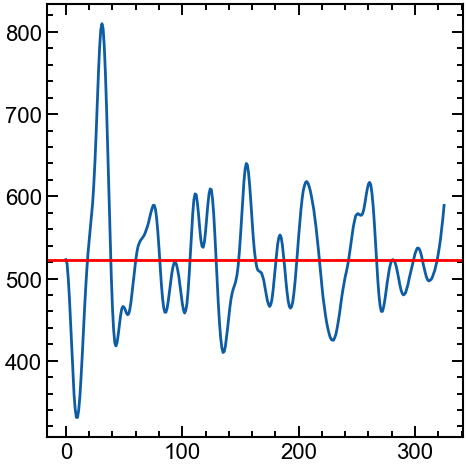

In [12]:
temperature_data = [
    523, 518, 501, 477, 447, 415, 385, 359, 341, 331, 331, 340, 356, 379, 405,
    434, 462, 488, 511, 531, 546, 561, 575, 592, 615, 643, 677, 715, 751, 782,
    803, 810, 804, 782, 748, 705, 654, 601, 549, 503, 465, 438, 422, 418, 422,
    432, 444, 455, 463, 466, 465, 462, 458, 456, 457, 463, 472, 484, 497, 510,
    522, 532, 539, 543, 546, 548, 550, 552, 555, 559, 563, 568, 574, 580, 585,
    589, 589, 584, 573, 557, 537, 515, 494, 477, 465, 459, 459, 464, 473, 484,
    496, 506, 514, 519, 520, 517, 511, 503, 492, 481, 470, 462, 458, 461, 469,
    485, 506, 531, 557, 579, 596, 603, 602, 592, 578, 561, 547, 539, 538, 544,
    557, 574, 590, 603, 609, 608, 597, 579, 554, 526, 497, 469, 446, 428, 416,
    410, 411, 417, 428, 440, 453, 466, 476, 483, 488, 492, 497, 504, 515, 531,
    551, 574, 597, 618, 633, 640, 638, 628, 612, 592, 570, 550, 534, 522, 514,
    510, 509, 508, 507, 503, 498, 490, 482, 474, 469, 466, 468, 474, 485, 499,
    514, 529, 542, 550, 553, 550, 541, 528, 514, 498, 484, 473, 466, 464, 466,
    472, 483, 497, 514, 532, 551, 568, 584, 597, 607, 613, 617, 618, 616, 612,
    607, 600, 592, 584, 573, 562, 549, 535, 520, 505, 491, 477, 466, 456, 447,
    440, 434, 429, 426, 425, 425, 428, 432, 439, 447, 456, 467, 477, 486, 494,
    502, 508, 515, 523, 533, 543, 553, 563, 570, 576, 578, 579, 578, 577, 577,
    579, 584, 592, 601, 609, 615, 617, 614, 604, 589, 569, 546, 522, 499, 480,
    467, 460, 460, 465, 473, 483, 494, 503, 512, 518, 522, 523, 522, 519, 514,
    507, 500, 492, 486, 482, 480, 481, 483, 488, 493, 500, 506, 512, 518, 524,
    530, 534, 537, 537, 535, 531, 525, 518, 512, 506, 501, 498, 497, 498, 499,
    502, 506, 510, 516, 522, 530, 539, 549, 561, 574, 589]

plt.plot(temperature_data)
plt.axhline(y=np.mean(temperature_data), color='r', linestyle='-')
print(np.mean(temperature_data))
print(np.std(temperature_data))